In [1]:
# libraries
import time
from random import seed
from random import randint
import csv
import matplotlib.pyplot as plt
import numpy as np

# Effectiveness analysis
Given LiME_binning clustering and the classification output, the goal of this notebook is assessing in what extent our procedure of reassignment (Total and/or Partial standard or zero) can be effective.


In [2]:
# path to classifier output
classifier_path = "../../../Bio_Project/SimDataset/classifiers_results/strex_kraken1_250000.res"

# classifier name
classifier_name = 'Kraken1'

# path to dataset
dataset_path = "../../../Bio_Project/SimDataset/reads_datasets/all_250000_1.fq"

# dataset file format: True if fasta, False if fastq
isFasta = False

# path to output file of binning procedure
clusters_path = "../../../LiME_binning results/paired/all_250000_1+RC.fasta.a40.t40.txt"

### Utility functions

In [3]:
def load_classifier_result(path):

    classification = open(path, 'r')
    classifier_results = {}

    for line in classification:
        col = []
        for j in range(0, len(line.split())):
            col.append(line.split()[j])
        
        classifier_results[col[0]] = col[1]

    classification.close()

    return classifier_results 


def load_dataset(path, datset_format : bool):

    dataset = open(path, "r")
    dataset_lines = []

    if (datset_format):
        divisor = 2
    else:
        divisor = 4

    index = 0
    for line in dataset:
        if (index%divisor==0):
            read_id = line.split()[0]
            dataset_lines.append(read_id[1: len(read_id)-2])
        index = index + 1

    dataset.close()

    return dataset_lines


def load_clusters_result(path):

    clusters = open(path, "r")
    clusters_list = []

    for group in clusters:
        clusters_list.append(int(group))

    clusters.close()

    return clusters_list


# clustering is a list of cluster index, one for each read of the dataset
# dataset is a list of read
# return a dict of (cluster, list of reads belonging to the cluster) pairs
def clustering_dict(clustering, dataset):
    
    clustering_dict = {}
    
    for line in range(len(dataset)):
        
        if clustering[line] not in clustering_dict.keys():
            
            clustering_dict[clustering[line]] = []
            clustering_dict[clustering[line]].append(dataset[line])
            
        else:
            
            clustering_dict[clustering[line]].append(dataset[line])
        
    return clustering_dict


# clustering_dict is a dictionary of (cluster, list of reads belonging to the cluster) pairs
# classifier is a dict of (read, label) pairs
# return a dictionary of (cluster, list of labels of the reads beloging to the cluster) pairs
def label_clustering(clustering_dict, classifier):
    
    label_clustering_dict = {}
    
    for cluster, read_list in clustering_dict.items():
        
        label_clustering_dict[cluster] = []
        
        for read in read_list:
            
            if read in classifier.keys():
                
                label_clustering_dict[cluster].append(classifier[read])
                
            else:
                
                label_clustering_dict[cluster].append('0')
    
    return label_clustering_dict


# label_clustering is a dictionary of (cluster, list of labels of the reads beloging to the cluster) pairs
# return a list of [cluster, cardinality] pairs such that alle labels in cluster are equal to '0' 
# and cardinality is the number of labels (or equivalently reads) in the cluster
def patological_cluster(label_clustering):
    
    patological_cluster_list = []
    
    for cluster, label_list in label_clustering.items():
        
        patological = True # boolean to inform wheter the cluster in examination is patological or not

        for label in label_list:
            
            if label != '0': # found one element different from zero in the cluster in examination --> the cluster is not patological                  
                patological = False
                break
        
        if patological:
            patological_cluster_list.append([cluster, len(label_list)])
    
    
    return patological_cluster_list


def number_patological_read(patological_cluster_list):
    
    number_patological_read = 0
    
    for cluster in patological_cluster_list:
        number_patological_read = number_patological_read + cluster[1]
    
    return number_patological_read


# dict --> (class, occurences)
def frequency_search(cluster):
    
    label_dict = {}

    for label in cluster:

        if label in list(label_dict):
            label_dict[label] = label_dict[label] + 1
            
        else:
            # if it does not exist, it's automatically created
            label_dict[label] = 1

    return label_dict


# It takes in input a dictionary that contains {label: frequency} pairs.
# Returns a pair {label: frequency} with maximal frequency.
# Ties broken randomly.
def get_max_label(label_dict): 
    
    seed(1)
    ties = False
    zero_ties = False
    
    candidates = [] # list of max label candidates
    
    max_frequency = 0
    
    for label, frequency in label_dict.items(): # find max frequency
        
        if frequency > max_frequency:
            max_frequency = frequency
    
    for label, frequency in label_dict.items(): # find labels with frequency equals to max frequency
        
        if frequency == max_frequency:
            candidates.append(label)
    
    # check if ties occur
    if len(candidates) > 1:
        # check if ties occur and '0' is a potencial candidate to become the max label of the cluster
        if '0' in candidates:
            zero_ties = True
        
        ties = True

    value = randint(0, len(candidates) - 1)  # choose randomly the label with max frequency if there are multiple candidate labels

    max_label = candidates[value]
         
    return [max_label, max_frequency, ties, zero_ties]

### Load the needed files for the analysis

In [4]:
# load classifier output
classifier = load_classifier_result(classifier_path)

# load dataset
dataset = load_dataset(dataset_path, isFasta)

# load binning output
clustering = load_clusters_result(clusters_path) 

### Pathological clusters and pathological reads

In [5]:
# get cluster dict
cluster_dict = clustering_dict(clustering, dataset)

# get cluster label dict
cluster_label_dict = label_clustering(cluster_dict, classifier)

# get patological clusters
patological_cluster_list = patological_cluster(cluster_label_dict)
# print percentage of patological clusters (must be smaller than number of patological reads of course)
print("Percentage of pathological clusters: ", len(patological_cluster_list)/len(cluster_dict)*100, "%")

# get number of patological reads
num_patological_read = number_patological_read(patological_cluster_list)
print("Percentage of pathological reads: ", num_patological_read/len(dataset)*100, "%")

Percentage of pathological clusters:  5.258509460630648 %
Percentage of pathological reads:  2.108064 %


### Ties and zero ties

In [6]:
max_label_per_cluster_list = []

num_ties = 0
num_zero_ties = 0

for cluster, label_list in cluster_label_dict.items():

        # return a dictionary with {label: frequency} pairs that appear in the examinated cluster
        lab_dict = frequency_search(label_list)
        
        max_label = get_max_label(lab_dict)

        # check if a tie happen
        if max_label[2]:
            # check if it is a zero tie
            if max_label[3]: 
                num_zero_ties = num_zero_ties + 1
            
            num_ties = num_ties + 1
    
        # append the quartet [cluster, max label, max frequency, number of total reads in the cluster]
        max_label_per_cluster_list.append([cluster, max_label[0], max_label[1], len(label_list)])

print("Percentage of clusters with ties in max label: ", num_ties/len(cluster_dict)*100, "%")
print("Percentage of clusters with ties in max label with '0' as candidate with respect to clusters with ties: ", num_zero_ties/num_ties*100, "%")
print("Percentage of clusters with ties in max label with '0' as candidate: ", num_zero_ties/len(cluster_dict)*100, "%")

Percentage of clusters with ties in max label:  4.064083249343982 %
Percentage of clusters with ties in max label with '0' as candidate with respect to clusters with ties:  9.661085855785934 %
Percentage of clusters with ties in max label with '0' as candidate:  0.3926345719697368 %


### Majority zero clusters, zero and non zero reads

In [7]:
majority_zero_clusters = 0 # number of clusters where the most frequent label zero is zero and 
                           # then if we apply the total reassignment all reads will be labelled with class '0'
                           # NOTE THAT I don't take in account patological clusters but only those that contain at least one read with label different from '0'
        
num_zero_read = 0 # overall number of reads classified with '0' label among these clusters

num_non_zero_read = 0 # overall number of reads that will be labelled with label '0' but 
                      # that were classified with a label different from '0' before TOTAL reassignment

patological_cluster_list_no_length = []
patological_cluster_dict_no_length = {}

for element in patological_cluster_list:
    patological_cluster_dict_no_length[element[0]] = element[0]

for element in max_label_per_cluster_list:
    
    if element[1] == '0' and element[0] not in patological_cluster_dict_no_length.keys():
        
        majority_zero_clusters = majority_zero_clusters + 1 
        num_zero_read = num_zero_read + element[2]
        num_non_zero_read = num_non_zero_read + element[3] - element[2]

        # for debugging
        if element[3] == element[2]:
            print("The code doesn't work properly: PATOLOGICAL clusters are being considered!!")

print("num_zero_read: ", num_zero_read)
print("majority_zero_clusters: ", majority_zero_clusters)
print("num_non_zero_read: " , num_non_zero_read)

num_zero_read:  252535
majority_zero_clusters:  3172
num_non_zero_read:  84343


### Partial vs Total reassignment (standard version)

In [8]:
# number of reads with label zero after TOTAL reassignment procedure
non_lab_read_tot = num_non_zero_read + num_patological_read + num_zero_read
print("Number of reads with label zero after TOTAL alignment procedure: ", non_lab_read_tot)

# number of reads with label zero after PARTIAL reassignment procedure
non_lab_read_par = num_zero_read + num_patological_read
print("Number of reads with label zero after PARTIAL alignment procedure: ", non_lab_read_par)

# difference in labelled reads
print("Difference in non labelled reads between TOTAL and PARTIAL : ", non_lab_read_tot - non_lab_read_par)

Number of reads with label zero after TOTAL alignment procedure:  402755
Number of reads with label zero after PARTIAL alignment procedure:  318412
Difference in non labelled reads between TOTAL and PARTIAL :  84343


### Output file generation

Running the cell below will generate a .csv file containing the results of the analysis performed. <br>
The file is called: <b><i>classifier_name</i>_effectiveness</b>, where 'classifier_name' depends on the value specified in the begginning of the notebook.

In [9]:
num_cluster = len(cluster_dict)
patological_cluster = len(patological_cluster_list)
num_read = len(dataset)
patological_read = num_patological_read
zero_cluster = majority_zero_clusters
zero_read= num_zero_read
non_zero_read = num_non_zero_read
ties = num_ties
zero_ties = num_zero_ties

outfile = 'output files/' + classifier_name + '_effectiveness.csv'
with open(outfile, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Parameter", "Value"])
    writer.writerow(["classifier", str(classifier_name)])
    writer.writerow(["num_cluster", num_cluster])
    writer.writerow(["patological_cluster", patological_cluster])
    writer.writerow(["num_reads", num_read])
    writer.writerow(["patological_read", patological_read])
    writer.writerow(["zero_cluster", zero_cluster])
    writer.writerow(["zero_reads", zero_read])
    writer.writerow(["non_zero_read", non_zero_read])
    writer.writerow(["ties", ties])
    writer.writerow(["zero_ties", zero_ties])

## Effectiveness plot generation

In [10]:
# number of clusters to plot, largest k clusters will be taken into account
k = 20

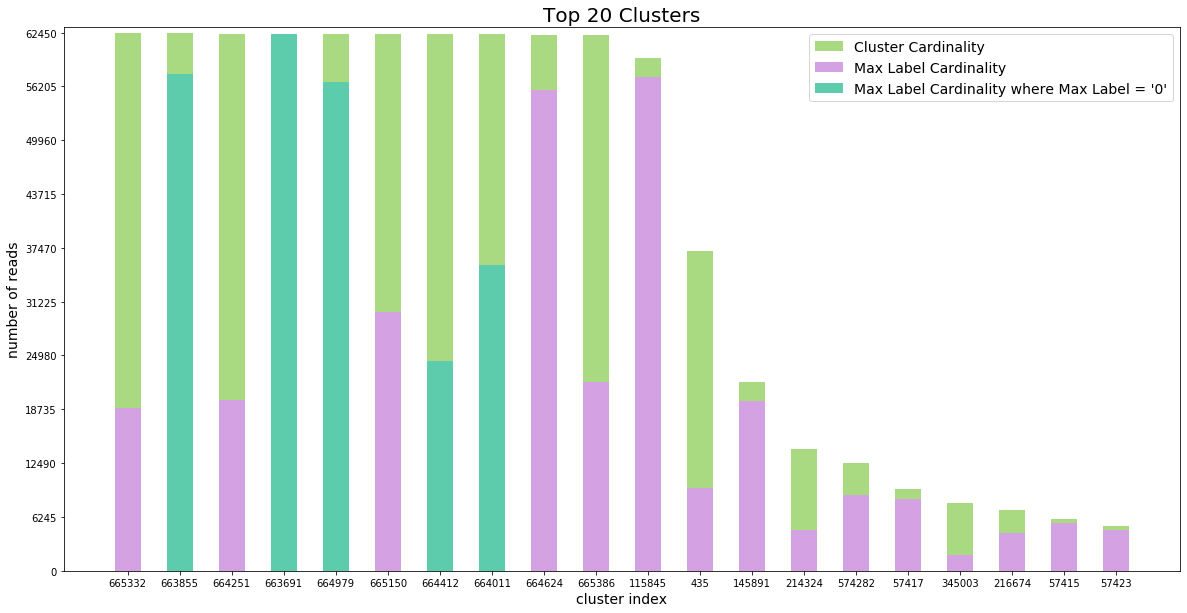

In [11]:
## cluster_dict is a dict of {cluster : [read_ids]} 
## cluster_label_dict id a dict of {cluster : [labels]}
## max_label_per_cluster_list is a list of quartet [cluster_index, max_label, max_frequency, cluster length]

cluster_cardinality = {}

for cluster, read_list in cluster_dict.items(): 
    cluster_cardinality[cluster] = len(read_list)

sorted_tuples = sorted(cluster_cardinality.items(), key=lambda item: item[1], reverse = True)
sorted_dict = {k: v for k, v in sorted_tuples}

top_k_cluster = {}
i = 0
for cluster, cardinality in sorted_dict.items():    
    if i <= k:       
        top_k_cluster[cluster] = cardinality   
    else:
        break        
    i = i + 1
    
#print(top_k_cluster)

top_cluster_info = []
for cluster, label_list in cluster_label_dict.items():
    
    if cluster in top_k_cluster.keys():    
        
        # return a dictionary with {label: frequency} pairs that appear in the examinated cluster
        lab_dict = frequency_search(label_list)
        
        max_label = get_max_label(lab_dict) 
        
        if max_label[0] == '0':
            top_cluster_info.append([cluster, max_label[0], max_label[1], len(label_list), True])
            
        else:
            top_cluster_info.append([cluster, max_label[0], max_label[1], len(label_list), False])
            
top_cluster_info = sorted(top_cluster_info, key=lambda x: x[3], reverse=True)

#for element in top_cluster_info:
   #print(element)

clusters = []
max_labels = []
max_frequency = []
cluster_length = []
zero_cluster = []

for i in range(0, k):
    clusters.append(str(top_cluster_info[i][0]))
    max_labels.append(top_cluster_info[i][1])
    max_frequency.append(top_cluster_info[i][2])
    cluster_length.append(top_cluster_info[i][3])
    
    if top_cluster_info[i][4]:
        zero_cluster.append(top_cluster_info[i][2])
    
    else:
        zero_cluster.append(0)

width = 0.50      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(clusters, cluster_length, width, label='Cluster Cardinality', color='#A9D981')
ax.bar(clusters, max_frequency, width, label='Max Label Cardinality', color='#D4A2E2')
ax.bar(clusters, zero_cluster, width, label='Max Label Cardinality where Max Label = \'0\'', color='#5CCCAC')

plt.ylim(0, round(max(cluster_length) +  max(cluster_length)/100))
plt.yticks(np.arange(0, round(max(cluster_length) +  max(cluster_length)/100), round(max(cluster_length)/10)))

fig.set_size_inches(20, 10)

ax.set_ylabel('number of reads', fontsize = 14)
ax.set_xlabel('cluster index', fontsize = 14)
ax.set_title('Top ' + str(k) + ' Clusters', fontsize = 20)
ax.legend(fontsize = 14)

fig.savefig('output files/' + classifier_name + '-EffectivenssGraph.png')

plt.show()